In [2]:
import torch.nn as nn
import os
import numpy as np
import torch
import random

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 3
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h



In [6]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                            stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                            stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                            stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [7]:
from collections import namedtuple

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                            n_blocks = [1, 1, 1],
                            channels = [64, 128, 256])

In [8]:
import torch.optim as optim
import torch

# instantiate the model, define the loss function and optimizer
model = ResNet(resnet18_config, output_dim=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002) # use Adam algo to optimize gradient descend

In [ ]:
import os
import numpy as np


#Load all image file paths from a directory with valid extensions.
def load_filepaths(target_dir): 
    paths = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    files = os.listdir(target_dir)
    for file in files:
        if file.endswith(valid_extensions):
            paths.append(f"{target_dir}/{file}")    # list all file names in the folder
    return paths

#Prepare dataset by collecting file paths and corresponding labels.
def prepare_data(target_dir):
    filepaths = []
    labels = []

    for i in range(4):
        fpaths = load_filepaths(target_dir + str(i))
        labels += [i] * len(fpaths)
        filepaths += fpaths # += add elements individually. append() will add the entire list

    return np.array(filepaths), torch.tensor(labels)

dir_train = "train/"
filepaths, labels = prepare_data(dir_train)

In [ ]:
from torchvision import transforms
from PIL import Image

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# Load and preprocess multiple images for model training
def load_images(filepaths):
    # Instantiate class to resize and transform image to tensor
    transform = transforms.Compose([
        transforms.Resize((pretrained_size, pretrained_size)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean = pretrained_means, 
                            std = pretrained_stds)
    ])

    tensor = None

    # List all files in the directory
    for item in filepaths:
        image = Image.open(item).convert("RGB")     # force 3 channels
        img_tensor = transform(image) # convert into pytorch's tensor to work with

        # Initialize or concatenate to batch tensor
        if tensor is None:
            # size: [1,1,28,28]
            tensor = img_tensor.unsqueeze(0) # add a new dimension at specified index. in this case, added dimension is for batch dimension
        else:
            # concatenate becomes [2,1,28,28], [3,1,28,28], [4,1,28,28] ...
            # dim=0 concatenates along the axis=0 (row-wise)
            tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

    return tensor

In [ ]:
# prepare to load images when testing
def load_test_images(filepaths):
    # Instantiate class to resize and transform image to tensor
    transform = transforms.Compose([
        transforms.Resize((pretrained_size, pretrained_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean = pretrained_means,
                            std = pretrained_stds)
    ])

    tensor = None

    # List all files in the directory
    for item in filepaths:
        image = Image.open(item).convert("RGB")     # force 3 channels
        img_tensor = transform(image) # convert into pytorch's tensor to work with


        if tensor is None:
            # size: [1,1,28,28]
            tensor = img_tensor.unsqueeze(0) # add a new dimension at specified index. in this case, added dimension is for batch dimension
        else:
            # concatenate becomes [2,1,28,28], [3,1,28,28], [4,1,28,28] ...
            # dim=0 concatenates along the axis=0 (row-wise)
            tensor = torch.cat((tensor, img_tensor.unsqueeze(0)), dim=0)

    return tensor

In [ ]:
from sklearn.model_selection import train_test_split

# Split filepaths and labels into train and validation sets (90% train, 10% val)
train_filepaths, val_filepaths, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.1, stratify=labels, random_state=42
)

print(f"Train samples: {len(train_filepaths)}, Validation samples: {len(val_filepaths)}")

Train samples: 565, Validation samples: 63


In [ ]:
# Training loop with validation
n_epochs = 15
batch_size = 64
history = { "loss": [], "accuracy": [], "val_loss": [], "val_accuracy": [] }

# --- Training Phase ---
for epoch in range(n_epochs):
    model.train()
    samples_trained = 0
    run_loss = 0
    correct_preds = 0
    total_samples = len(train_filepaths)
    
    # Create randomized batch indices for epoch
    permutation = torch.randperm(total_samples)
    
    # Batch training loop
    for i in range(0, total_samples, batch_size):
        # Get batch indices and data
        indices = permutation[i : i+batch_size]
        batch_inputs = load_images(train_filepaths[indices])
        batch_labels = train_labels[indices]
        
        # Forward pass
        outputs, _ = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        
        # Update training metrics
        history["loss"].append(loss.item())
        run_loss += loss.item() * len(batch_labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate batch accuracy
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, dim=1)
        samples_trained += len(batch_labels)
        correct_preds += torch.sum(preds == batch_labels)
        accuracy = correct_preds / float(samples_trained)
        history["accuracy"].append(accuracy)
        
    # Epoch training statistics
    avg_loss = run_loss / samples_trained

    # --- Validation Phase ---
    model.eval()
    val_loss = 0
    val_correct = 0
    val_samples = len(val_filepaths)
    
    # Disable gradient computation
    with torch.no_grad():
        for i in range(0, val_samples, batch_size):
            # Get validation batch
            batch_inputs = load_test_images(val_filepaths[i : i+batch_size])
            batch_labels = val_labels[i : i+batch_size]
            
            # Forward pass
            outputs, _ = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            
            # Update validation metrics
            val_loss += loss.item() * len(batch_labels)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs, dim=1)
            val_correct += torch.sum(preds == batch_labels)
            
    # Epoch validation statistics
    avg_val_loss = val_loss / val_samples
    val_accuracy = val_correct / float(val_samples)
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(val_accuracy)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}: Train Loss={avg_loss:.5f}, Train Acc={accuracy:.5f}, Val Loss={avg_val_loss:.5f}, Val Acc={val_accuracy:.5f}")

/opt/anaconda3/envs/mlaenv/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Loss=0.90297, Train Acc=0.65133, Val Loss=1.15837, Val Acc=0.68254
Epoch 2: Train Loss=0.64324, Train Acc=0.79469, Val Loss=0.73121, Val Acc=0.80952
Epoch 3: Train Loss=0.56014, Train Acc=0.84602, Val Loss=0.77997, Val Acc=0.66667
Epoch 4: Train Loss=0.47641, Train Acc=0.86372, Val Loss=0.61236, Val Acc=0.74603
Epoch 5: Train Loss=0.46187, Train Acc=0.85664, Val Loss=0.54427, Val Acc=0.77778
Epoch 6: Train Loss=0.44528, Train Acc=0.87080, Val Loss=0.44241, Val Acc=0.87302
Epoch 7: Train Loss=0.39199, Train Acc=0.88850, Val Loss=0.50028, Val Acc=0.77778
Epoch 8: Train Loss=0.36356, Train Acc=0.90619, Val Loss=0.43475, Val Acc=0.80952
Epoch 9: Train Loss=0.30293, Train Acc=0.92035, Val Loss=0.40043, Val Acc=0.88889
Epoch 10: Train Loss=0.30315, Train Acc=0.91504, Val Loss=0.50848, Val Acc=0.76190
Epoch 11: Train Loss=0.27838, Train Acc=0.92920, Val Loss=0.29023, Val Acc=0.90476
Epoch 12: Train Loss=0.28436, Train Acc=0.92212, Val Loss=0.50190, Val Acc=0.80952
Epoch 13: Tra

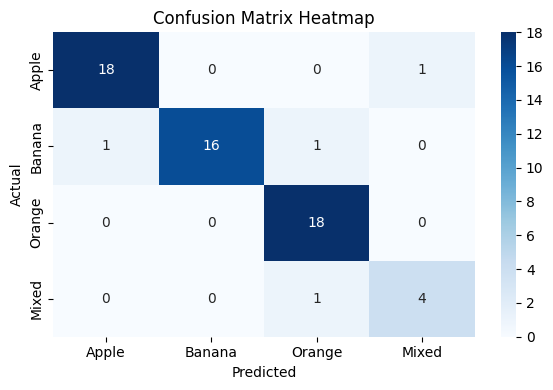

Overall Accuracy: 0.93333
Apple Accuracy: 0.94737
Banana Accuracy: 0.88889
Orange Accuracy: 1.00000
Mixed Accuracy: 0.80000


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# --- Model Evaluation on Test Set ---
dir_test = "test/"
filepaths, labels = prepare_data(dir_test)

# Evaluation configuration
batch_size = 60
total_samples = len(filepaths)

# Initialize prediction tracking
all_preds = []
all_labels = []

# Evaluation mode - disable gradient computation
model.eval()
with torch.no_grad():
    for i in range(0, total_samples, batch_size):
        # Load and process batch
        batch_inputs = load_test_images(filepaths[i: i + batch_size])
        batch_labels = labels[i: i + batch_size]

        # Model inference
        outputs, _ = model(batch_inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, dim=1)

        # Store results
        all_preds.extend(preds.numpy())
        all_labels.extend(batch_labels.numpy())

# --- Performance Analysis ---
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Class labels
class_names = ['Apple', 'Banana', 'Orange', 'Mixed']

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

# Compute per-class accuracy
cm_tensor = torch.tensor(cm)
class_totals = cm_tensor.sum(dim=1)
correct_per_class = cm_tensor.diag()
class_accuracies = correct_per_class / class_totals

# Calculate overall accuracy
total_correct = cm_tensor.diag().sum().item()
overall_accuracy = total_correct / total_samples

# Print results
print(f"Overall Accuracy: {overall_accuracy:.5f}")
for i, cls in enumerate(class_names):
    print(f"{cls} Accuracy: {class_accuracies[i]:.5f}")

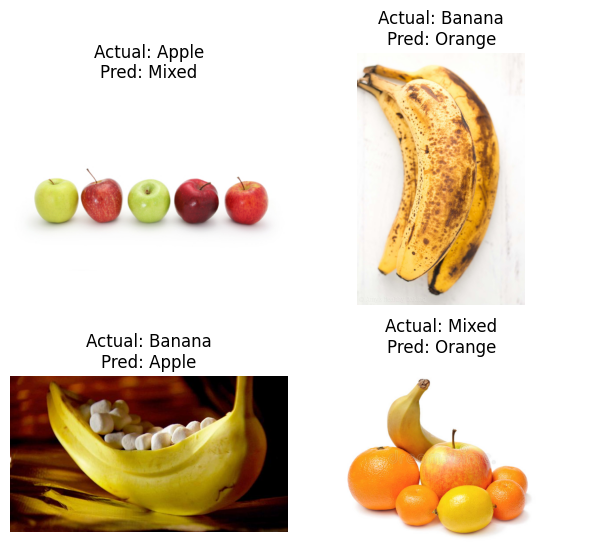

In [ ]:
from PIL import Image
import math

# Show up to 15 misclassified images in a square grid layout
max_to_show = 15
misclassified = []

# Identify misclassified examples by comparing predictions with ground truth
for idx, (pred, actual) in enumerate(zip(all_preds, all_labels)):
    if pred != actual:
        img_path = filepaths[idx]
        misclassified.append((img_path, actual, pred))
        if len(misclassified) >= max_to_show:
            break

# Handle case where all predictions are correct
if len(misclassified) == 0:
    print("No misclassified images found.")
else:
    # Calculate grid dimensions: square root rounded up for NxN grid
    n = len(misclassified)
    grid_size = math.ceil(math.sqrt(n))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(3*grid_size, 3*grid_size))
    axes = axes.flatten()
    
    # Display each misclassified image with annotation
    for i, (img_path, actual, pred) in enumerate(misclassified):
        img = Image.open(img_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Actual: {class_names[actual]}\nPred: {class_names[pred]}")
        
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    # Adjust layout to prevent label overlap
    plt.tight_layout()
    plt.show()

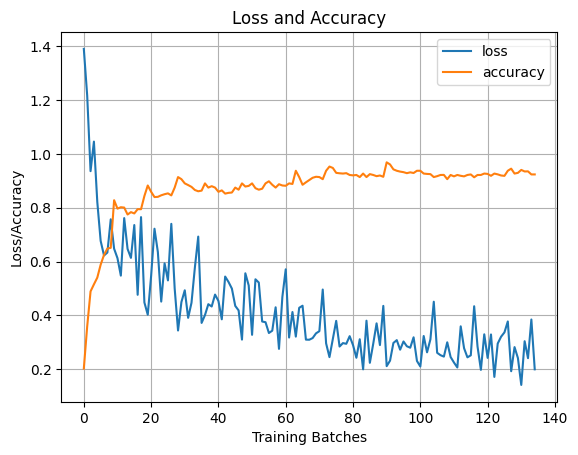

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

loss_per_batch = np.arange(len(history["loss"]))

# plot loss and accuracy per training batch
plt.plot(loss_per_batch, history["loss"], label="loss")
plt.plot(loss_per_batch, history["accuracy"], label="accuracy")
plt.xlabel("Training Batches")
plt.ylabel("Loss/Accuracy")
plt.title("Loss and Accuracy")
plt.legend()
plt.grid()
plt.show()